# Setup

In [1]:
import os
import glob

import cv2
import numpy as np
from PIL import Image

import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

from pylibdmtx.pylibdmtx import decode, DmtxSymbolSize
from ultralytics import YOLO, settings
root_dir = os.getcwd().replace('\\notebooks', '')
settings.update({'datasets_dir': f'{root_dir}/data/processed/test', 'runs_dir': f'{root_dir}/yolo/runs'})

import torch
import torch.nn as nn
from torchvision.transforms import v2, InterpolationMode
from torchvision.models.resnet import ResNet18_Weights
from torchvision import models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_size = 9000

## Loading Models

In [2]:
model_yolo = YOLO('../yolo/models/ultralytics_finetuned.pt')

In [3]:
# Class definition copied from image_binarizer.ipynb
class binarizer(nn.Module):
    def __init__(self):
        super(binarizer, self).__init__()

        # Load the pretrained ResNet-18 model
        resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)

        # Use the ResNet layers up to the last layer (remove the fully connected layer)
        self.encoder = nn.Sequential(*list(resnet18.children())[:-2]) # output size = 512 x 8 x 8

        # Define the decoder part to upsample back to 512 x 512
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid() # Use sigmoid for binary output in range [0, 1]
        )

    def forward(self, x):
        '''Pass input through the resnet-18 encoder and custom decoder'''
        # print('FORWARD A')
        x = self.encoder(x)
        # print('FORWARD B')
        x = self.decoder(x)
        return x

# Load the trained model
model_binarizer = binarizer().to(device)
model_binarizer.load_state_dict(torch.load('../torch/binarizer_19.pt'))
model_binarizer.eval()

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

## Custom Normalization

In [4]:
# transformation to convert images to tensors (no normalization yet)
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

# function to compute mean and std
def calculate_mean_std(image_paths, transform):
    channel_sum = torch.zeros(3)
    channel_squared_sum = torch.zeros(3)
    num_pixels = 0

    for path in image_paths:
        # load and transform the image
        image = Image.open(path).convert('RGB') # ensure 3-channel RGB images
        tensor = transform(image)

        # accumulate sum and squared sum of pixel values
        channel_sum += tensor.sum(dim=(1, 2))
        channel_squared_sum += (tensor ** 2).sum(dim=(1, 2))
        num_pixels += tensor.size(1) * tensor.size(2) # H * W

    # calculate mean and std
    mean = channel_sum / num_pixels
    std = ((channel_squared_sum / num_pixels) - mean ** 2).sqrt()

    return mean, std

# Compute mean and std for the dataset
# mean, std = calculate_mean_std(glob.glob('../data/synth_data/noisy/*.png')[:train_size], transform)
# print(f'Mean: {mean}')
# print(f'Std: {std}')

In [14]:
# Function to prepare image for model input
def prepare_image(img):
    transform = v2.Compose([
        v2.Resize((512, 512), interpolation=InterpolationMode.BILINEAR), # Resize to match model input
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # ResNet normalization
        # v2.Normalize(mean=mean, std=std) # custom normalization
    ])

    img = transform(img).unsqueeze(0).to(device)
    return img

(512, 512)


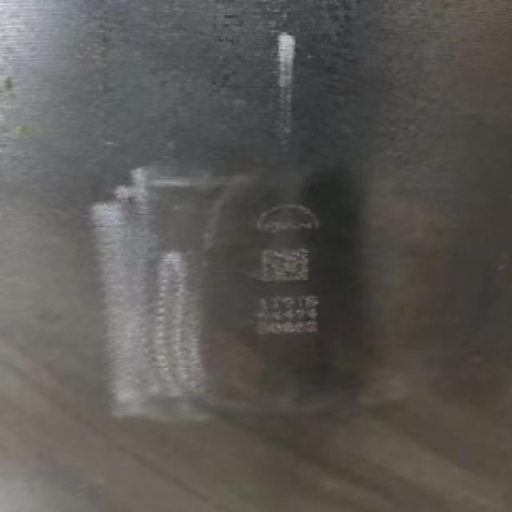

In [15]:
# testing image preparer
# img = Image.open('../data/MAN/images/test/1G9V68937920005_jpeg.rf.8cf4ab8c3c91d302bcc6d81776399c39.jpg')
img = Image.open('../data/MAN/images/test/1T9T86449480002_png.rf.b1383adab83ee9487e97f4f40327676d.jpg')
img = prepare_image(img)
img = v2.ToPILImage()(img[0].squeeze(0))
print(img.size)
display(img)

## Evaluation Function

In [7]:
def decoding_pipeline(yolo_model, binarizer_model, test_data_path):
    '''
    Performs cropping and decoding of the images
    '''
    img_paths = glob.glob(test_data_path)

    # stat tracking
    num_decodings = 0
    num_valid_decodings = 0

    imgs = []
    titles = []

    idx = 0
    for img_path in img_paths:
        img = cv2.imread(img_path)
        results = yolo_model(img)
        boxes = results[0].boxes.xyxy.tolist()

        actual_decoding = os.path.basename(img_path).split('_')[0]
        actual_decoding = actual_decoding.replace('-', '') # minor cleaning

        # fixing some actual decodings
        if actual_decoding == 'KV8INMEP':
            actual_decoding = '#D1FPE50HA9NS0047XG264##KV8INMEP'
        elif actual_decoding == 'KW8PXY3D':
            actual_decoding = '#D1FPE50HA9NS0047XG264##KW8PXY3D'

        if boxes != None and len(boxes) > 0:
            # only look at box with highest confidence
            box = boxes[0]

            # crop with some padding (to not have too small of a crop)
            pad = 45
            crop_obj = img[max(0, int(box[1])-pad):max(0, int(box[3])+pad), max(0, int(box[0])-pad):max(0, int(box[2])+pad)]

            # convert image for use in binarizer
            crop_obj = Image.fromarray(crop_obj)
            crop_obj_prep = prepare_image(crop_obj)
            display(v2.ToPILImage()(crop_obj_prep[0].squeeze(0)))

            # binarize with model
            output = binarizer_model(crop_obj_prep)

            # binarize with threshold
            pred = (output > 0.5).float()
            # display(v2.ToPILImage()(pred[0].squeeze(0)))

            # convert to numpy for decoding
            converted = pred[0].squeeze(0).cpu().numpy().astype(np.uint8) * 255
            display(Image.fromarray(converted))
            
            # decode with params used in data synthesis
            decoded = decode(converted,
                             max_count=1,
                             threshold=50,
                             min_edge= 20,
                             max_edge=800,
                             shape=DmtxSymbolSize.DmtxSymbol16x16,
                             timeout=1000,
                             )
            # decoded = decode(converted)

            if decoded:
                num_decodings += 1

                decoded_string = decoded[0].data.decode('utf-8')

                if decoded_string == actual_decoding:
                    print(f'Valid decoding! {actual_decoding}')
                    num_valid_decodings += 1
                    imgs.append(Image.fromarray(converted))
                    titles.append(actual_decoding)
                else:
                    print('Invalid decoding!')
                    print(actual_decoding)
                    print(decoded_string)

            # optional saving
            cv2.imwrite(f'../data/cropped/{actual_decoding}-{idx}.jpg', crop_obj)
            idx += 1

    # calculate stats
    dm_decode_rate = num_decodings/len(img_paths)
    valid_decode_rate = num_valid_decodings/len(img_paths)

    print()
    print(f'{num_valid_decodings}/{len(img_paths)}')
    print(f'Dm decode rate: {dm_decode_rate}')
    print(f'Valid decode rate: {valid_decode_rate}')
    # print_save_imgs(imgs, titles, fig_title)

# Running Evaluation


0: 640x640 1 Data Matrix, 150.7ms
Speed: 6.0ms preprocess, 150.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


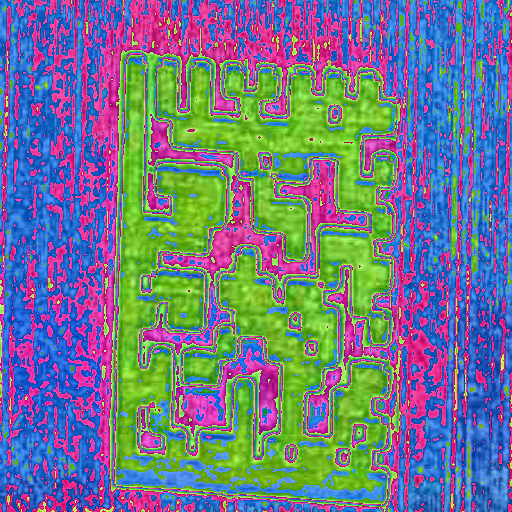

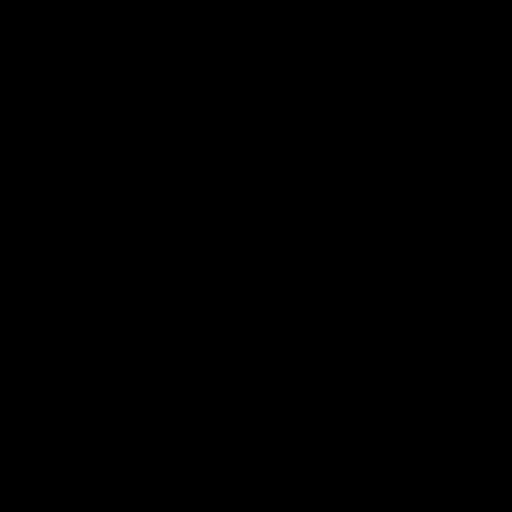


0: 640x640 1 Data Matrix, 121.8ms
Speed: 5.8ms preprocess, 121.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


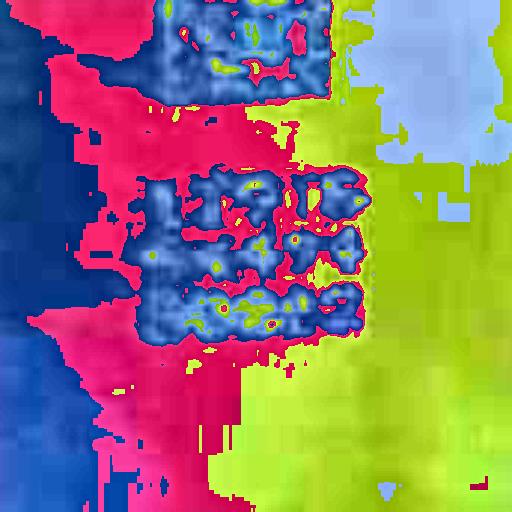

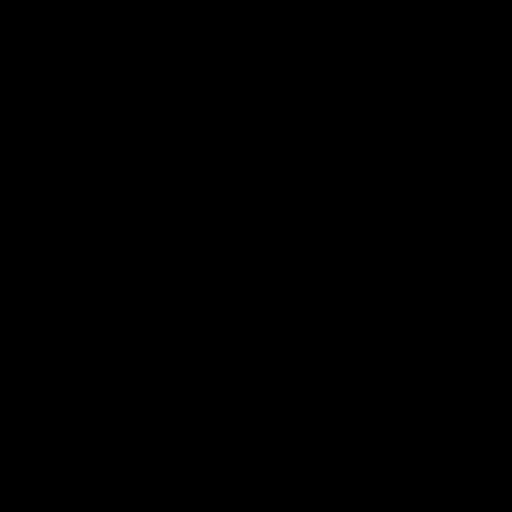


0: 640x640 1 Data Matrix, 117.8ms
Speed: 4.9ms preprocess, 117.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


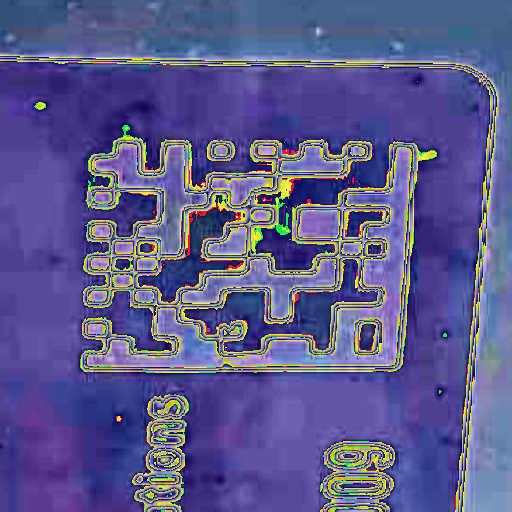

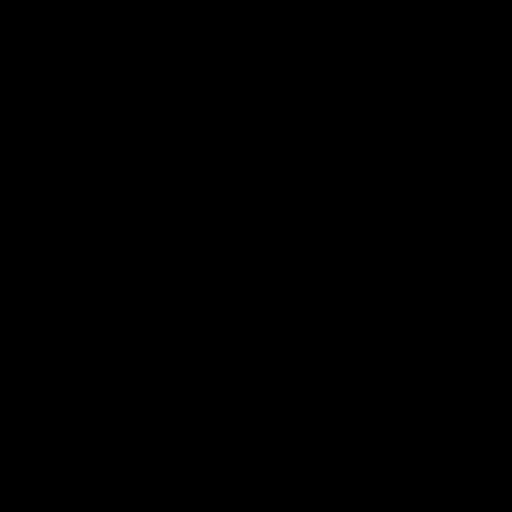


0: 640x640 1 Data Matrix, 104.7ms
Speed: 5.1ms preprocess, 104.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


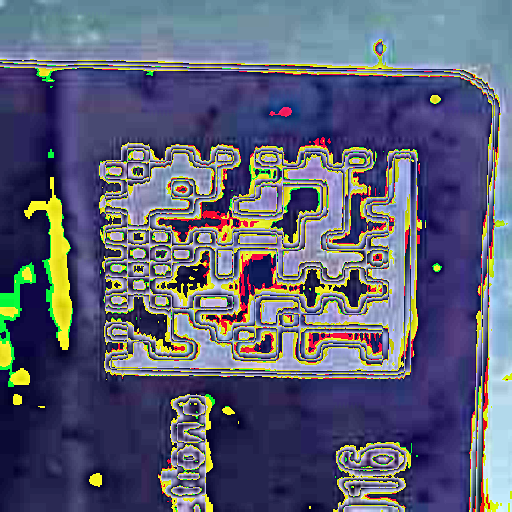

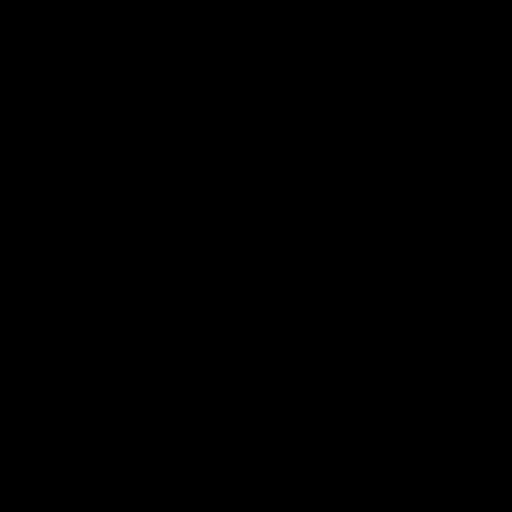


0: 640x640 1 Data Matrix, 136.5ms
Speed: 0.0ms preprocess, 136.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


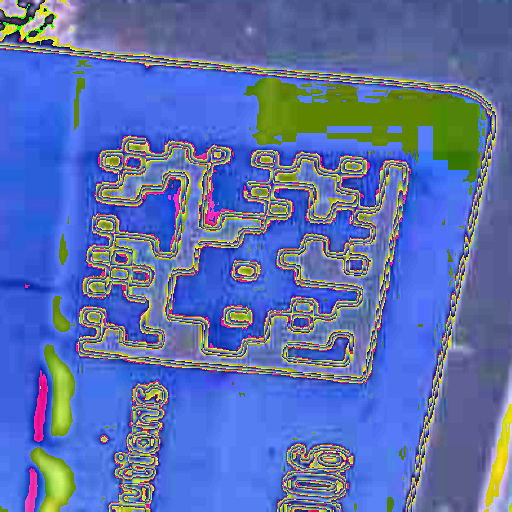

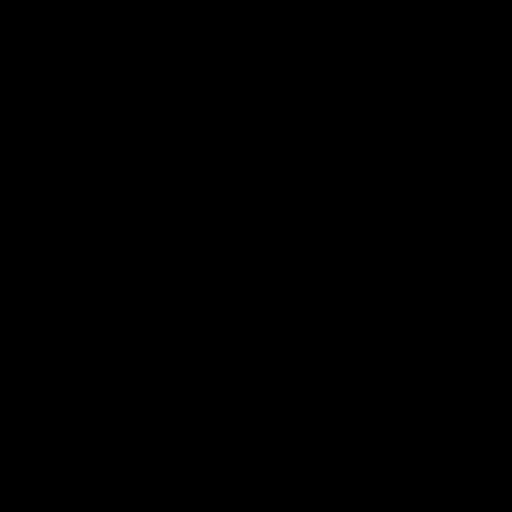


0: 640x640 1 Data Matrix, 177.8ms
Speed: 3.6ms preprocess, 177.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


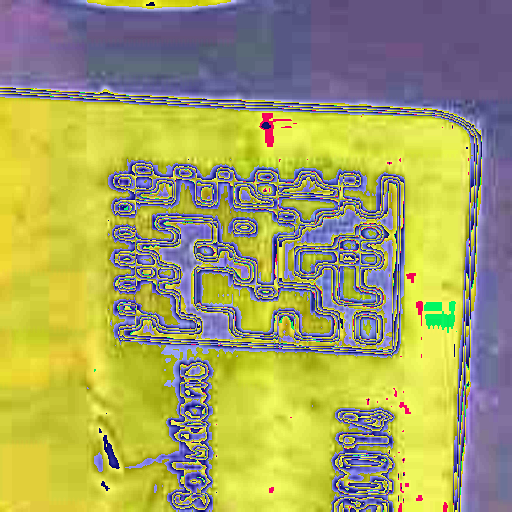

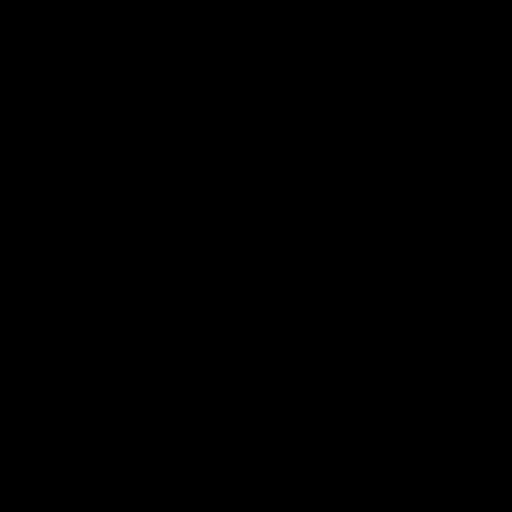


0: 640x640 1 Data Matrix, 144.7ms
Speed: 25.9ms preprocess, 144.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


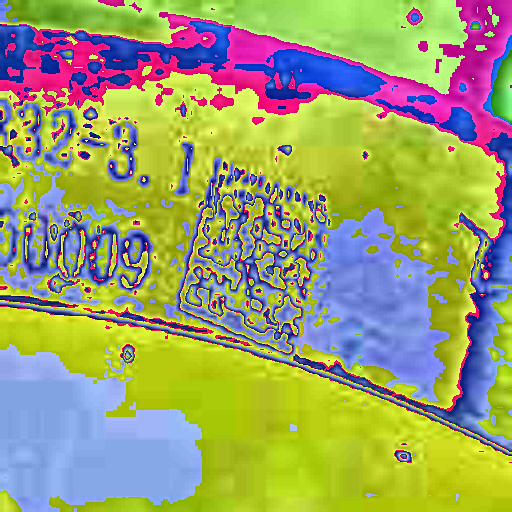

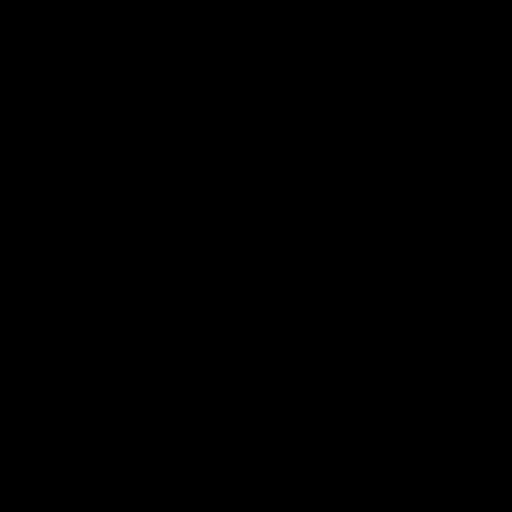


0: 640x640 1 Data Matrix, 97.1ms
Speed: 3.8ms preprocess, 97.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


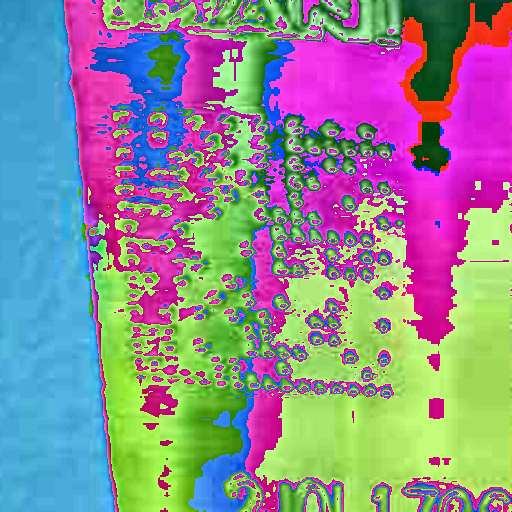

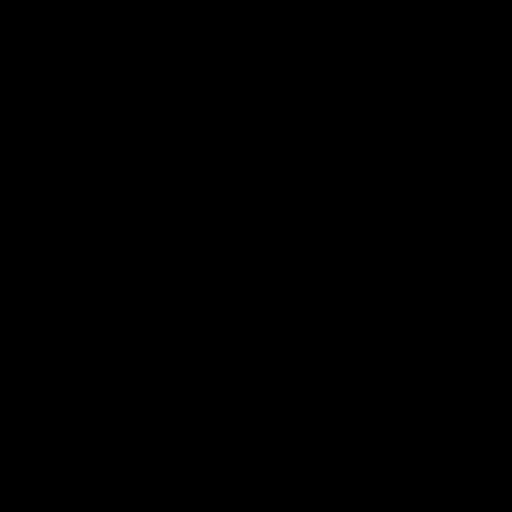


0: 640x640 1 Data Matrix, 246.6ms
Speed: 2.2ms preprocess, 246.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


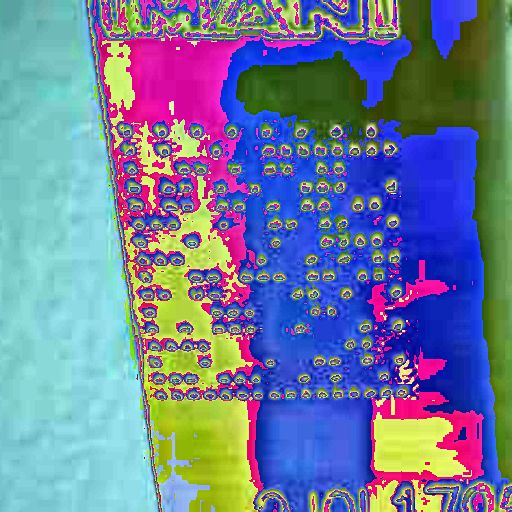

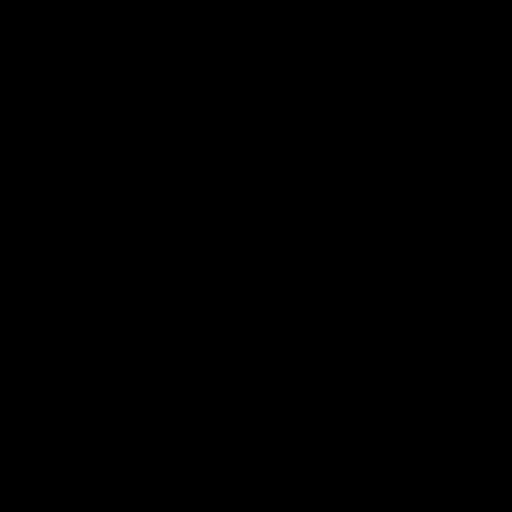


0: 640x640 1 Data Matrix, 127.4ms
Speed: 7.6ms preprocess, 127.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


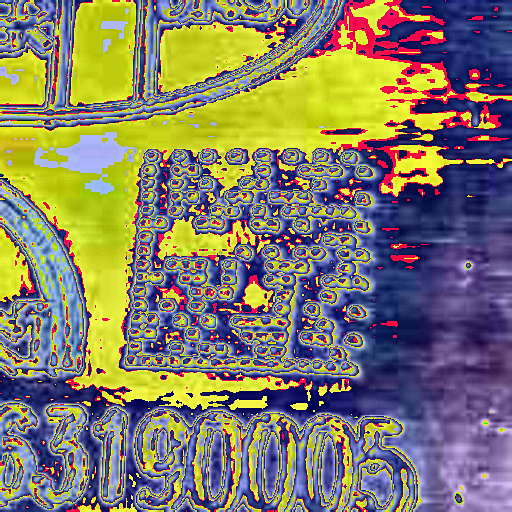

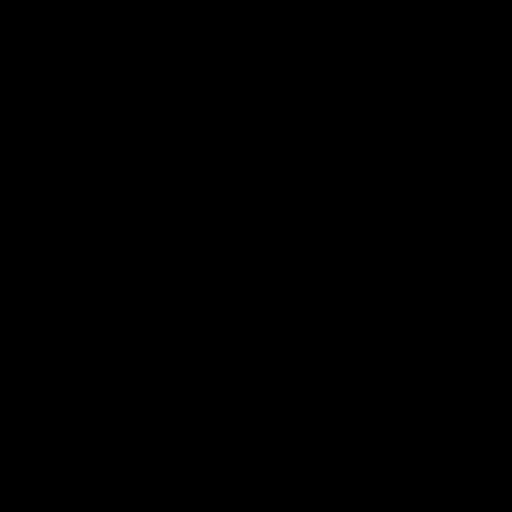


0: 640x640 1 Data Matrix, 231.9ms
Speed: 3.1ms preprocess, 231.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


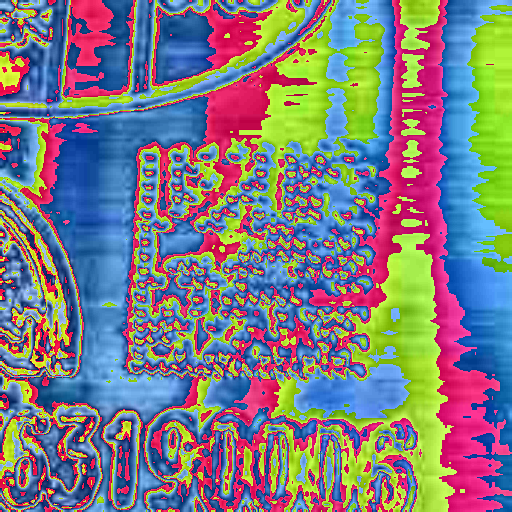

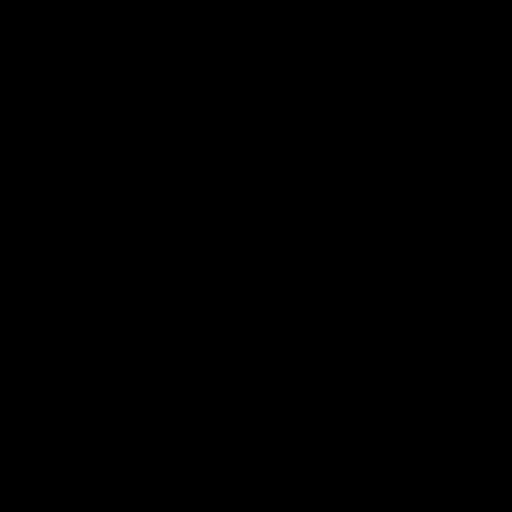


0: 640x640 1 Data Matrix, 129.0ms
Speed: 0.0ms preprocess, 129.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


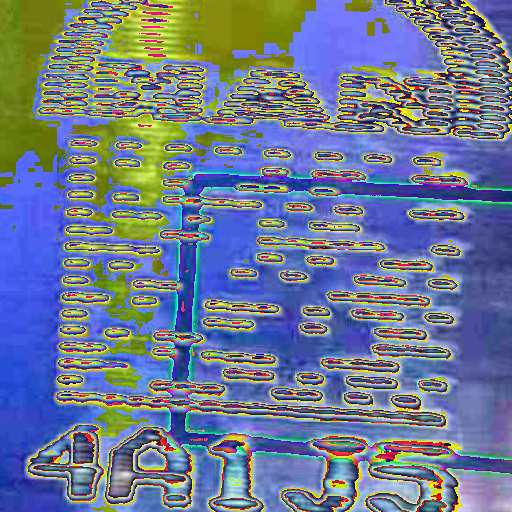

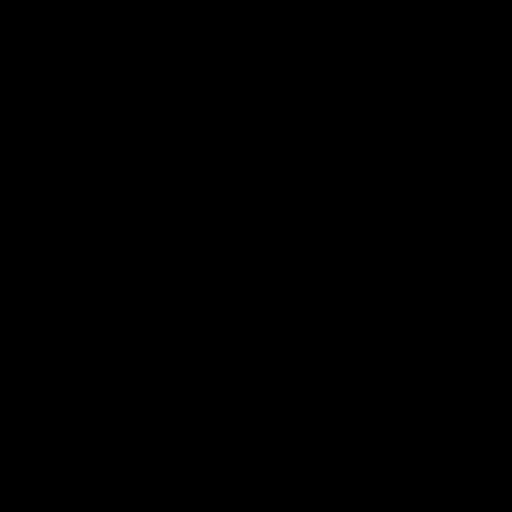


0: 640x640 1 Data Matrix, 115.1ms
Speed: 4.2ms preprocess, 115.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


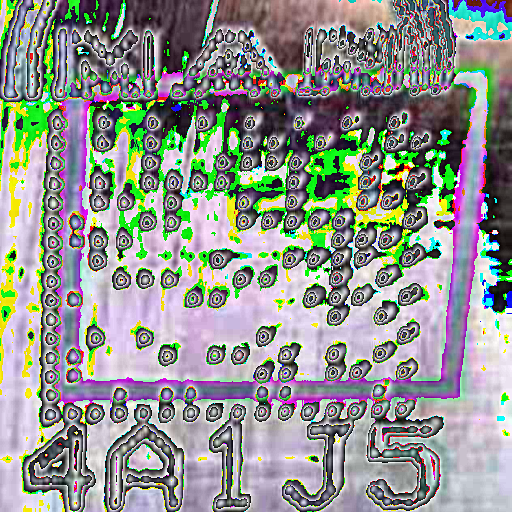

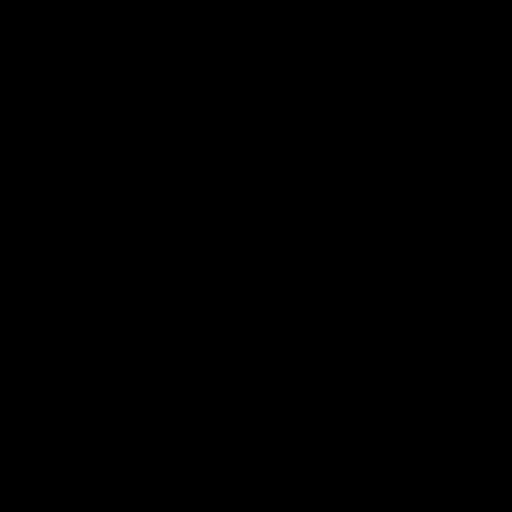


0: 640x640 2 Data Matrixs, 184.5ms
Speed: 0.7ms preprocess, 184.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


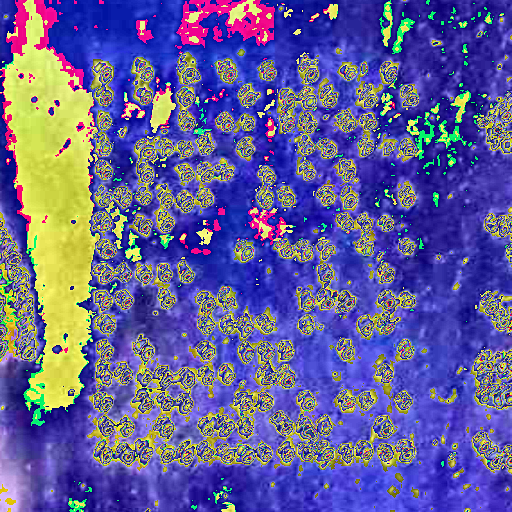

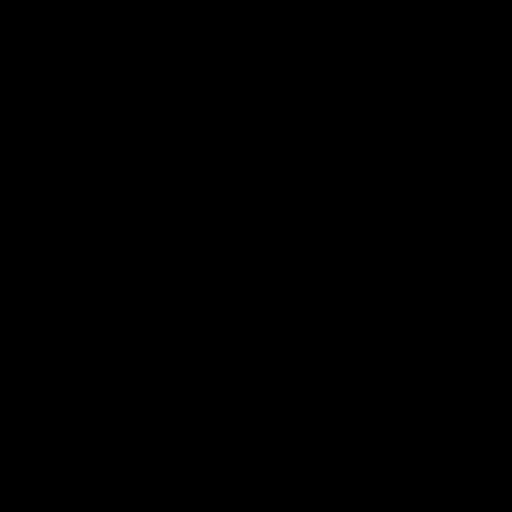

KeyboardInterrupt: 

In [8]:
decoding_pipeline(model_yolo, model_binarizer, f'{root_dir}/data/MAN/images/test/*')